In [1]:
import time
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import random

import sys
sys.path.append('../')
from cnn.commons import inc_convolution, inc_convolution2
from cnn.commons import inc_max_pool, inc_max_pool2

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Theoretical and Eperical Speedups

In [2]:
batch_size = 256
in_channels = 128
in_size = 112
out_channels = in_channels
out_size = in_size
k_size = 3

conv = True

In [3]:

theoretical_speedup = []
emperical_speedup = []
best_achievable_speedup = []
cudnn_speedup = []

in_tensor = torch.FloatTensor(batch_size, in_channels,  in_size, in_size).random_(0, 10)
weights = torch.FloatTensor(out_channels, in_channels, k_size, k_size).random_(0, 10)
biases = torch.FloatTensor(out_channels).random_(0, 10)

in_tensor, weights, biases = in_tensor.cuda(), weights.cuda(), biases.cuda()

conv_module = torch.nn.Conv2d(in_channels, out_channels, k_size, padding=1, stride=1).cuda()
conv_module.weight.data = weights
conv_module.bias.data = biases
conv_module = torch.nn.Sequential(conv_module, torch.nn.ReLU(inplace=True))
max_pool_module = torch.nn.MaxPool2d(kernel_size=2, stride=2)

in_tensor, weights, biases = Variable(in_tensor), Variable(weights), Variable(biases)


#full inference
if conv:
    temp = conv_module(in_tensor)
else:
    temp = max_pool_module(in_tensor)
    
torch.cuda.synchronize()
prev_time = time.time()
for i in range(5):
    if conv:
        out_ptch = conv_module(in_tensor)
    else:
        out_ptch = max_pool_module(in_tensor)
    torch.cuda.synchronize()
torch.cuda.synchronize()
full_time = (time.time()-prev_time)/5/batch_size

x = range(1, in_size//2, k_size-1)
x_label = []

for p_size in x:
    
    #sanity check
    if p_size >= in_size:
        continue
    else:
        x_label.append(p_size)

    x_loc = [random.choice(range(0, in_size-p_size)) for _ in range(batch_size)]
    y_loc = [random.choice(range(0, in_size-p_size)) for _ in range(batch_size)]
    locations = torch.from_numpy(np.array(zip(x_loc, y_loc), dtype=np.int32))
    #locations = [(1,1), (1,5)]
    
    #patch size equvalient full inference
    in_tensor_prime = Variable(torch.FloatTensor(batch_size, in_channels,  p_size+(k_size-1), p_size+(k_size-1)).fill_(1.0).cuda())
    if conv:
        conv_module(in_tensor_prime)
    else:
        max_pool_module(in_tensor_prime)
        
    torch.cuda.synchronize()
    prev_time = time.time()
    for i in range(10):
        if conv:
            conv_module(in_tensor_prime)
        else:
            max_pool_module(in_tensor_prime)
        torch.cuda.synchronize()
    torch.cuda.synchronize()
    inc_best_time = (time.time()-prev_time)/10/batch_size
    
    #incremental inference
    patch_location_tensor = locations.cuda()
    if conv:
        inc_convolution2(in_tensor.data, in_tensor.data[:,:,0:p_size,0:p_size], weights.data, biases.data, out_ptch.data, patch_location_tensor, 112, 1, 1, p_height=p_size, p_width=p_size, beta=1.0)
    else:
        inc_max_pool(in_tensor, out_ptch, patch_location_tensor,
                    0, 2, 2, p_height=p_size, p_width=p_size)
    torch.cuda.synchronize()

    prev_time = time.time()
    for i in range(10):
        patch_location_tensor = locations.cuda()
        if conv:
            inc_convolution2(in_tensor.data, in_tensor.data[:,:,0:p_size,0:p_size], weights.data, biases.data, out_ptch.data,
                             patch_location_tensor, 112, 1, 1, p_height=p_size, p_width=p_size, beta=1.0)
        else:
            inc_max_pool(in_tensor, out_ptch, patch_location_tensor,
                    0, 2, 2, p_height=p_size, p_width=p_size, version=1)

        torch.cuda.synchronize()
    torch.cuda.synchronize()
    empr_time = (time.time()-prev_time)/10/batch_size
    
    #_, output_size = inc_conv_module(in_tensor, weights, biases, out_ptch, patch_location_tensor, 1, 1, k_size, p_height=p_size, p_width=p_size, version=4)
    #print(output_size)
    
    theoretical_speedup.append(1.0*out_size*out_size/(p_size+k_size-1)**2)
    best_achievable_speedup.append(full_time/inc_best_time)
    emperical_speedup.append(full_time/empr_time)

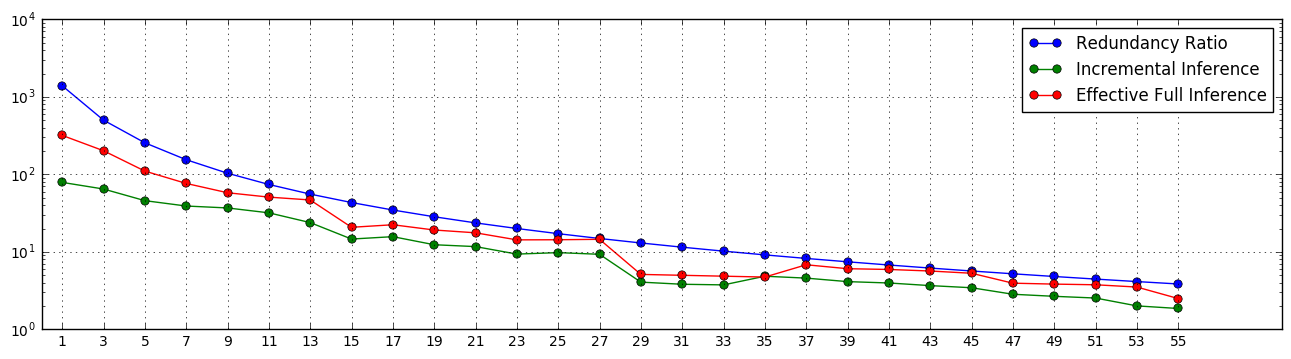

In [4]:
plt.rcParams["figure.figsize"] = (16,4)

# plt.xscale('log')
plt.yscale('log')
plt.plot(x_label, theoretical_speedup, label='Redundancy Ratio', marker='o')
plt.plot(x_label, emperical_speedup, label='Incremental Inference', marker='o')
plt.plot(x_label, best_achievable_speedup, label='Effective Full Inference', marker='o')
plt.xticks(x_label, x_label)
plt.legend()
plt.grid()
plt.show()

In [5]:
zip(x_label, theoretical_speedup, best_achievable_speedup, emperical_speedup)

[(1, 1393.7777777777778, 319.2296072507553, 78.98464509297038),
 (3, 501.76, 202.21353959014434, 64.85167757774141),
 (5, 256.0, 110.47046523784631, 45.898897757506646),
 (7, 154.8641975308642, 76.56190562449054, 39.136393098552425),
 (9, 103.6694214876033, 58.07497652689674, 36.95280283270433),
 (11, 74.22485207100591, 50.983293460123434, 31.96198782501292),
 (13, 55.75111111111111, 46.84078315478389, 23.916930737890446),
 (15, 43.40484429065744, 20.80087929394009, 14.66780031580226),
 (17, 34.74792243767313, 22.435770401302285, 15.74905448289996),
 (19, 28.444444444444443, 19.18943051288648, 12.389211054711737),
 (21, 23.71266540642722, 17.660872472004012, 11.722645957564831),
 (23, 20.0704, 14.313225267530592, 9.38153406778783),
 (25, 17.207133058984912, 14.369429350135707, 9.80047070826522),
 (27, 14.915576694411415, 14.553739497727378, 9.326982842641462),
 (29, 13.053069719042664, 5.129763209955458, 4.078817638912791),
 (31, 11.5188246097337, 4.9963649689396945, 3.8279450433669537

In [ ]:
zip(x_label, theoretical_speedup, best_achievable_speedup, emperical_speedup)

In [ ]:
np.sum(np.abs((temp-out_ptch).cpu().data.numpy().flatten()))

In [32]:
#temp
#out_ptch
#temp-out_ptch
#patch_location_tensor

import time
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import random

import sys
sys.path.append('../')
from cnn.commons import inc_convolution, inc_convolution2
from cnn.commons import inc_max_pool, inc_max_pool2


batch_size = 2
in_channels = 2
in_size = 12
out_channels = in_channels
out_size = in_size
k_size = 3

conv = True

In [33]:
p_size = 8

in_tensor = torch.FloatTensor(1, in_channels,  in_size, in_size).random_(0, 100).repeat(batch_size, 1, 1, 1)
weights = torch.FloatTensor(out_channels, in_channels, k_size, k_size).random_(0, 100)
biases = torch.FloatTensor(out_channels).random_(0, 100)

in_tensor, weights, biases = in_tensor.cuda(), weights.cuda(), biases.cuda()

conv_module = torch.nn.Conv2d(in_channels, out_channels, k_size, padding=1, stride=1).cuda()
conv_module.weight.data = weights
conv_module.bias.data = biases
conv_module = torch.nn.Sequential(conv_module)#, torch.nn.ReLU(inplace=True))

max_pool_module = torch.nn.MaxPool2d(kernel_size=2, stride=2)

in_tensor, weights, biases = Variable(in_tensor), Variable(weights), Variable(biases)

In [34]:
out_ptch = conv_module(in_tensor)
# out_ptch = max_pool_module(in_tensor)

In [35]:
p = in_size-p_size
locations = torch.from_numpy(np.array([(p, p)]*batch_size, dtype=np.int32))
patch_location_tensor = locations.cuda()

out_tensor = torch.FloatTensor(batch_size, in_channels, 10, 10).fill_(0).cuda()

In [36]:
inc_convolution2(in_tensor.data, in_tensor.data[:,:,p:p+p_size,p:p+p_size].clone(), weights.data, biases.data, out_tensor.data, patch_location_tensor,
                  224, 1, 1, p_height=p_size, p_width=p_size, beta=1.0)

(10, 10)

In [37]:
# inc_max_pool2(in_tensor.data, in_tensor.data[:,:,4:,4:].clone(), out_tensor.data, patch_location_tensor,
#               in_size/2, 0, 2, 2, p_height=p_size, p_width=p_size, beta=1.0)

In [38]:
temp1 = out_tensor[:,:,:,:].cpu().data
temp1.shape

torch.Size([2, 2, 10, 10])

In [39]:
temp2 = out_ptch.cpu().data[:,:,2:,2:]
temp2.shape

torch.Size([2, 2, 10, 10])

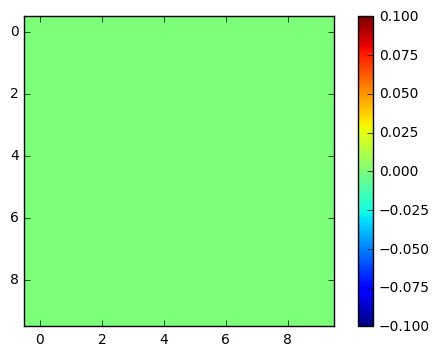

In [40]:
x = (temp2-temp1).cpu().data.numpy()
plt.imshow(x[0,0,:,:])
plt.colorbar()

In [41]:
#np.sum(np.abs(x))
temp1.shape

torch.Size([2, 2, 10, 10])

In [42]:
x[0,0,:,:]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [43]:
temp1[0,0]

tensor([[ 44608.,  46891.,  42038.,  42871.,  37305.,  39015.,  40295.,
          39957.,  36808.,  27276.],
        [ 34001.,  39457.,  38671.,  36666.,  34287.,  24695.,  33292.,
          27771.,  41639.,  29376.],
        [ 28115.,  37903.,  46450.,  32803.,  33841.,  29011.,  27034.,
          31751.,  31912.,  20348.],
        [ 32730.,  40012.,  46384.,  38556.,  27539.,  25932.,  38261.,
          29279.,  25451.,  27081.],
        [ 35705.,  35359.,  42275.,  33756.,  30690.,  34824.,  30357.,
          35479.,  40277.,  24202.],
        [ 31337.,  27038.,  33663.,  34801.,  37365.,  40425.,  42124.,
          36631.,  43470.,  37046.],
        [ 31240.,  22371.,  28946.,  29612.,  47891.,  49111.,  39259.,
          39673.,  37008.,  37180.],
        [ 36280.,  26204.,  24606.,  33043.,  35155.,  46079.,  35550.,
          33668.,  33954.,  32212.],
        [ 34422.,  26602.,  30516.,  30349.,  38655.,  30383.,  37939.,
          36066.,  36382.,  22890.],
        [ 21766.,  

In [61]:
#hari eka
temp2[0,0]

tensor([[ 98.,  94.,  63.],
        [ 38.,  78.,  95.],
        [ 90.,  70.,  94.]])

In [62]:
in_tensor.data[0,0,:,:]

tensor([[  3.,   3.,  47.,  60.,  51.,  63.,   4.,   3.],
        [ 36.,  87.,  41.,  14.,  40.,  89.,  77.,  59.],
        [ 18.,  51.,  71.,  98.,  13.,  94.,   2.,  63.],
        [ 95.,  36.,  27.,   7.,  16.,  64.,  48.,   4.],
        [ 79.,  95.,  38.,  11.,  57.,  78.,  27.,  67.],
        [ 80.,  30.,  16.,  28.,  11.,  11.,  95.,  65.],
        [ 88.,  80.,  90.,  19.,  27.,  33.,  94.,  55.],
        [  6.,  43.,  76.,  61.,  70.,  35.,  88.,  31.]], device='cuda:0')

In [63]:
in_tensor.data[:,:,4:,4:]

tensor([[[[ 57.,  78.,  27.,  67.],
          [ 11.,  11.,  95.,  65.],
          [ 27.,  33.,  94.,  55.],
          [ 70.,  35.,  88.,  31.]]]], device='cuda:0')